## Trading Project
Edoardo Lupotto , Giacomo Magnani

To run the code you must have a real or demo account of Interactive Brokers

In [1]:
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from ib_insync import *
util.startLoop()  # uncomment this line when in a notebook

In [3]:
# Connect to Interactive Brokers - taken from trading lesson Programming II
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=1) #Port 7496 is reserved for real account, while 7497 for demo

<IB connected to 127.0.0.1:7497 clientId=1>

In [ ]:
#taken from trading lesson Programming II
myAccount = ib.accountSummary()
myAccount

In [5]:
#write down the account number
myAccount = '...'

In [6]:
#download historical data
contract = Forex('EURUSD')
bars = ib.reqHistoricalData(
    contract, 
    endDateTime='', 
    durationStr='30 D',
    barSizeSetting='30 mins', 
    whatToShow='MIDPOINT', 
    useRTH=0
    )

In [7]:
# convert to a pandas dataframe:
df = util.df(bars)
df.head(10)

,date,open,high,low,close,volume,average,barCount
0,2024-05-12 17:15:00-04:00,1.077225,1.077395,1.076860,1.077005,-1.0,-1.0,-1
1,2024-05-12 17:30:00-04:00,1.077005,1.077215,1.076775,1.077145,-1.0,-1.0,-1
2,2024-05-12 18:00:00-04:00,1.077145,1.077365,1.077090,1.077270,-1.0,-1.0,-1
3,2024-05-12 18:30:00-04:00,1.077270,1.077310,1.077115,1.077305,-1.0,-1.0,-1
4,2024-05-12 19:00:00-04:00,1.077305,1.077540,1.077230,1.077385,-1.0,-1.0,-1
5,2024-05-12 19:30:00-04:00,1.077385,1.077420,1.077015,1.077025,-1.0,-1.0,-1
6,2024-05-12 20:00:00-04:00,1.077025,1.077235,1.076825,1.076925,-1.0,-1.0,-1
7,2024-05-12 20:30:00-04:00,1.076925,1.077060,1.076825,1.076930,-1.0,-1.0,-1
8,2024-05-12 21:00:00-04:00,1.076930,1.077200,1.076685,1.077190,-1.0,-1.0,-1
9,2024-05-12 21:30:00-04:00,1.077190,1.077325,1.076770,1.076900,-1.0,-1.0,-1


In [8]:
fig = px.line(df, x='date', y='close', title='EURUSD - Close Prices')  # creating a figure using px.line
display(fig)  # showing figure in output

## Calculating MACD Indicator

In [9]:
df['EMA12'] = df['close'].ewm(span=12, adjust=False).mean()

In [10]:
df['EMA26'] = df['close'].ewm(span=26, adjust=False).mean()

In [11]:
df['MACD'] = df['EMA12'] - df['EMA26']

In [12]:
df['Signal_line'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [13]:
# Define the conditions for buying and selling
last_row = df.iloc[-1]
second_last_row = df.iloc[-2]

print(f'last_row MACD: {last_row["MACD"]}')
print(f'last_row Signal_line: {last_row["Signal_line"]}')
print(f'second_last_row MACD: {second_last_row["MACD"]}')
print(f'second_last_row Signal_line: {second_last_row["Signal_line"]}')

last_row MACD: -0.0005439387474299728
last_row Signal_line: -0.0005584595052753048
second_last_row MACD: -0.0005678323297646504
second_last_row Signal_line: -0.0005620896947366377


In [14]:
if second_last_row['MACD'] > second_last_row['Signal_line'] and last_row['MACD'] < last_row['Signal_line']:
    print("cross below")

elif second_last_row['MACD'] < second_last_row['Signal_line'] and last_row['MACD'] > last_row['Signal_line']:
    print("cross above")

else: 
    print("no cross")

cross above


In [15]:
# Plotting the MACD and Signal Line
fig_macd = px.line(df, x='date', y=['Signal_line','MACD'], title='MACD and Signal Line', labels={'Signal_line': 'Signal Line'})

# Setting the appearance for the Signal Line, ensuring it shows up in the legend as red
fig_macd.update_traces(line=dict(width=2))

# Adjusting legend to show both lines properly and removing the y-axis label
fig_macd.update_layout(
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    legend_title_text=None,
    xaxis_title='Date',
    yaxis_title=None
)

# Display the plot
fig_macd.show()

## Calculating RSI Indicator

In [16]:
# setting the RSI Period
rsi_period = 7

In [17]:
# to calculate RSI, we first need to calculate the exponential weighted aveage gain and loss during the period
df['gain'] = (df['close'] - df['open']).apply(lambda x: x if x > 0 else 0)
df['loss'] = (df['close'] - df['open']).apply(lambda x: -x if x < 0 else 0)

In [18]:
# here we use the same formula to calculate Exponential Moving Average
df['ema_gain'] = df['gain'].ewm(span=rsi_period, min_periods=rsi_period).mean()
df['ema_loss'] = df['loss'].ewm(span=rsi_period, min_periods=rsi_period).mean()

In [19]:
# the Relative Strength is the ratio between the exponential avg gain divided by the exponential avg loss
df['rs'] = df['ema_gain'] / df['ema_loss']

In [20]:
# the RSI is calculated based on the Relative Strength
df['rsi'] = 100 - (100 / (df['rs'] + 1))

In [21]:
df.head(10)

,date,open,high,low,close,volume,average,barCount,EMA12,EMA26,MACD,Signal_line,gain,loss,ema_gain,ema_loss,rs,rsi
0,2024-05-12 17:15:00-04:00,1.077225,1.077395,1.076860,1.077005,-1.0,-1.0,-1,1.077005,1.077005,0.000000,0.000000,0.000000,0.00022,NaN,NaN,NaN,NaN
1,2024-05-12 17:30:00-04:00,1.077005,1.077215,1.076775,1.077145,-1.0,-1.0,-1,1.077027,1.077015,0.000011,0.000002,0.000140,0.00000,NaN,NaN,NaN,NaN
2,2024-05-12 18:00:00-04:00,1.077145,1.077365,1.077090,1.077270,-1.0,-1.0,-1,1.077064,1.077034,0.000030,0.000008,0.000125,0.00000,NaN,NaN,NaN,NaN
3,2024-05-12 18:30:00-04:00,1.077270,1.077310,1.077115,1.077305,-1.0,-1.0,-1,1.077101,1.077054,0.000047,0.000016,0.000035,0.00000,NaN,NaN,NaN,NaN
4,2024-05-12 19:00:00-04:00,1.077305,1.077540,1.077230,1.077385,-1.0,-1.0,-1,1.077145,1.077079,0.000066,0.000026,0.000080,0.00000,NaN,NaN,NaN,NaN
5,2024-05-12 19:30:00-04:00,1.077385,1.077420,1.077015,1.077025,-1.0,-1.0,-1,1.077126,1.077075,0.000052,0.000031,0.000000,0.00036,NaN,NaN,NaN,NaN
6,2024-05-12 20:00:00-04:00,1.077025,1.077235,1.076825,1.076925,-1.0,-1.0,-1,1.077095,1.077064,0.000032,0.000031,0.000000,0.00010,0.000038,0.000118,0.323933,24.467500
7,2024-05-12 20:30:00-04:00,1.076925,1.077060,1.076825,1.076930,-1.0,-1.0,-1,1.077070,1.077054,0.000016,0.000028,0.000005,0.00000,0.000029,0.000085,0.340227,25.385782
8,2024-05-12 21:00:00-04:00,1.076930,1.077200,1.076685,1.077190,-1.0,-1.0,-1,1.077088,1.077064,0.000025,0.000027,0.000260,0.00000,0.000091,0.000062,1.469926,59.512956
9,2024-05-12 21:30:00-04:00,1.077190,1.077325,1.076770,1.076900,-1.0,-1.0,-1,1.077059,1.077052,0.000008,0.000023,0.000000,0.00029,0.000067,0.000123,0.548467,35.419981


In [22]:
# displaying the results
display(df[['date', 'rsi', 'rs', 'ema_gain', 'ema_loss']])

,date,rsi,rs,ema_gain,ema_loss
0,2024-05-12 17:15:00-04:00,NaN,NaN,NaN,NaN
1,2024-05-12 17:30:00-04:00,NaN,NaN,NaN,NaN
2,2024-05-12 18:00:00-04:00,NaN,NaN,NaN,NaN
3,2024-05-12 18:30:00-04:00,NaN,NaN,NaN,NaN
4,2024-05-12 19:00:00-04:00,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1425,2024-06-21 09:30:00-04:00,29.360936,0.415647,0.000164,0.000395
1426,2024-06-21 10:00:00-04:00,60.410042,1.525893,0.000452,0.000296
1427,2024-06-21 10:30:00-04:00,37.047091,0.588489,0.000339,0.000576
1428,2024-06-21 11:00:00-04:00,42.591124,0.741891,0.000320,0.000432


In [23]:
# plotting the RSI
fig_rsi = px.line(df, x='date', y='rsi', title='RSI Indicator')

In [24]:
# RSI oversold and overbought levels
overbought_level = 50
orversold_level = 50

In [25]:
# adding oversold and overbought levels to the plot
fig_rsi.add_hline(y=overbought_level, opacity=0.5)
fig_rsi.add_hline(y=orversold_level, opacity=0.5)

## Calculating Stochastic Oscillator

In [26]:
period=7
k=3
d=3
df['HH'] = df['high'].rolling(period).max()
df['LL'] = df['low'].rolling(period).min()
df['%K'] = (100 * (df['close'] - df['LL']) / (df['HH'] - df['LL'])).rolling(k).mean()
df['%D'] = df['%K'].rolling(d).mean()
df.drop(['HH', 'LL'], axis=1, inplace=True)

In [27]:
# Assuming 'df' has a 'date' column for the x-axis
fig_stoch = px.line(df, x='date', y=['%K', '%D'], labels={'value': 'Stochastic Values', 'variable': 'Lines'}, title='Stochastic Oscillator')

# Customizing the lines
fig_stoch.update_traces(line=dict(width=2))
fig_stoch.update_layout(
    legend_title_text=None,
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    xaxis_title="Date",
    yaxis_title=None
)
# STOCH commonly uses oversold and overbought levels, usually at 80 and 20
overbought_level = 80
orversold_level = 20
# adding oversold and overbought levels to the plot
fig_stoch.add_hline(y=overbought_level, opacity=0.5)
fig_stoch.add_hline(y=orversold_level, opacity=0.5)
# Display the plot
fig_stoch.show()


In [28]:
# Drop the values that are not available
df.dropna(inplace=True)


In [29]:
# Define the colums date as index
df.set_index('date', inplace=True)

## Creating the Buying function

In [30]:
def gettriggers(df, lags, buy = True):
    dfx = pd.DataFrame()  # Initialize an empty DataFrame
    for i in range(1, lags+1):
        if buy:
            mask = (df['%K'].shift(i) < 20) & (df['%D'].shift(i) < 20)
        else:
            mask = (df['%K'].shift(i) > 80) & (df['%D'].shift(i) > 80)
        mask_df = mask.to_frame(name='trigger').T  # Convert the Series to a DataFrame and transpose it
        dfx = pd.concat([dfx, mask_df], ignore_index=True)  # Concatenate the current mask DataFrame to dfx
    return dfx.sum(axis=0)

In [31]:
lags=4

df['Buytrigger'] = np.where(gettriggers(df, lags, ),1,0)

df['Selltrigger'] = np.where(gettriggers(df, lags, False),1,0)

In [32]:
df['Buy'] = np.where((df.Buytrigger) &
            (df['%K'].between(20,80)) & (df['%D'].between(20,80)) & 
            (df.rsi > 50) & (df.MACD > 0),1,0)

In [33]:
df['Sell'] = np.where((df.Selltrigger) &
            (df['%K'].between(20,80)) & (df['%D'].between(20,80)) & 
            (df.rsi < 50) & (df.MACD < 0),1,0)

In [34]:
Buying_dates, Selling_dates = [], []

In [35]:
for i in range(len(df)-1):
    if df.Buy.iloc[i]:
        Buying_dates.append(df.iloc[i+1].name)
        for num, j in enumerate(df.Sell.iloc[i:]):
            if j:
                Selling_dates.append(df.iloc[i+num+1].name)
                break

In [36]:
cutit = len(Buying_dates) - len(Selling_dates)

In [37]:
if cutit:
    Buying_dates = Buying_dates[:-cutit]

In [38]:
data = pd.DataFrame({'Buying_dates': Buying_dates, 'Selling_dates': Selling_dates})

In [39]:
data

,Buying_dates,Selling_dates
0,2024-05-13 18:00:00-04:00,2024-05-16 14:30:00-04:00
1,2024-05-14 21:00:00-04:00,2024-05-16 14:30:00-04:00
2,2024-05-14 21:30:00-04:00,2024-05-16 14:30:00-04:00
3,2024-05-22 03:00:00-04:00,2024-05-22 21:00:00-04:00
4,2024-06-12 19:30:00-04:00,2024-06-16 19:30:00-04:00
5,2024-06-18 03:00:00-04:00,2024-06-21 03:30:00-04:00
6,2024-06-18 16:00:00-04:00,2024-06-21 03:30:00-04:00
7,2024-06-18 16:30:00-04:00,2024-06-21 03:30:00-04:00


Looking to the above dataframe we can see that there are multiple trade in the same periods, we can avoid the overlapping position looking if the buying date is larger than the shifted selling date


In [40]:
real = data[data.Buying_dates > data.Selling_dates.shift(1)]

In [41]:
real

,Buying_dates,Selling_dates
3,2024-05-22 03:00:00-04:00,2024-05-22 21:00:00-04:00
4,2024-06-12 19:30:00-04:00,2024-06-16 19:30:00-04:00
5,2024-06-18 03:00:00-04:00,2024-06-21 03:30:00-04:00


## Calculate the profits

In [42]:
def profitcalc():
    Buyprices = df.loc[real.Buying_dates].open
    Sellprices = df.loc[real.Selling_dates].open
    return (Sellprices.values - Buyprices.values) / Buyprices.values


In [43]:
profits = profitcalc()

In [44]:
profits

array([-0.00329606, -0.01022248, -0.00321433])

In [45]:
profits.mean()

-0.005577622539693968

In [46]:
(profits + 1).prod()

0.9833441709935765

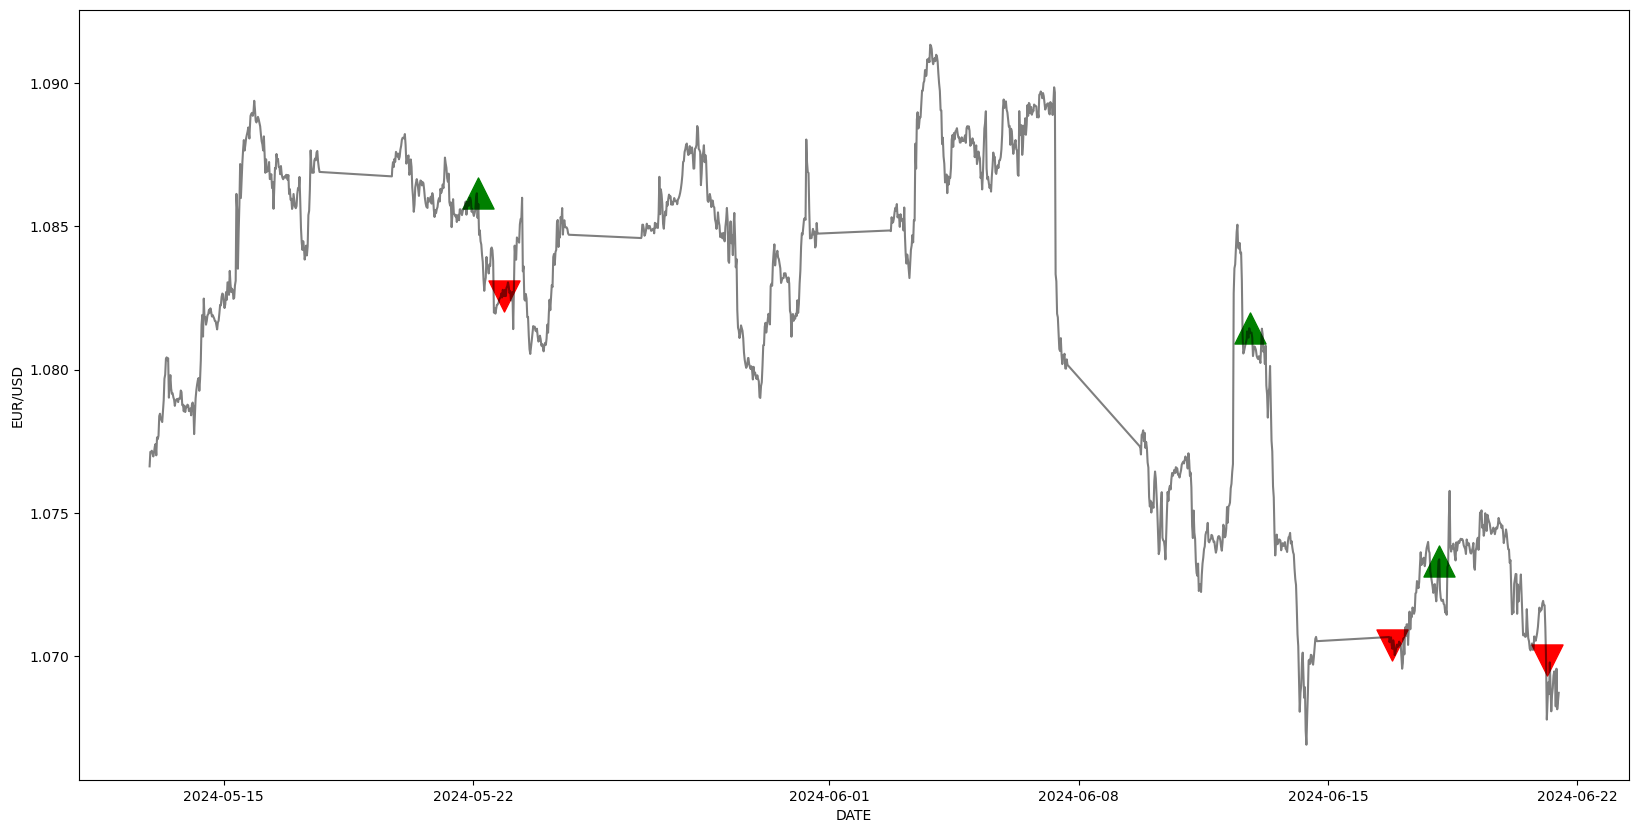

In [47]:
plt.figure(figsize=(20,10))
plt.plot(df.close, color='k', alpha=0.5)
plt.scatter(real.Buying_dates, df.open[real.Buying_dates], marker='^', color='g', s=500)
plt.scatter(real.Selling_dates, df.open[real.Selling_dates], marker='v', color='r', s=500)
plt.ylabel('EUR/USD')
plt.xlabel('DATE')  # Added y-axis label
plt.show()


## Place limit order

In [48]:
# conditions
thrsRetn     = 0.0001/100  # 0.01%
hold_seconds = 30
quantity     = 20000

In [ ]:
# Iterate over the DataFrame and create orders based on conditions
#the iteration can be interrupted by the User only manually

for index, row in df.iterrows():
    if row['Buy'] == 1:
        current_price = row['close']
        order = MarketOrder('BUY', quantity)
        trade = ib.placeOrder(contract, order)
        print(f'Placed BUY order at {current_price} for {quantity} units')
        time.sleep(hold_seconds)

    elif row['Sell'] == 1:
        current_price = row['close']
        order = MarketOrder('SELL', quantity)
        trade = ib.placeOrder(contract, order)
        print(f'Placed SELL order at {current_price} for {quantity} units')
        time.sleep(hold_seconds)